# LECTURE 15: The HR diagram

## IMPORT MODULES

In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## LOAD FILE

In [2]:
# Download data file. To do only if haven't done already (I assume)

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x7a17605930a0>)

In [9]:
df_stars = pd.read_csv("stars.csv")

df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


# 1 - VISUALIZE DATA

In [22]:
le = LabelEncoder()

# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])

labels = le.inverse_transform(df_stars['Star type']) # star type of each object
class_names = le.classes_ # star types considered

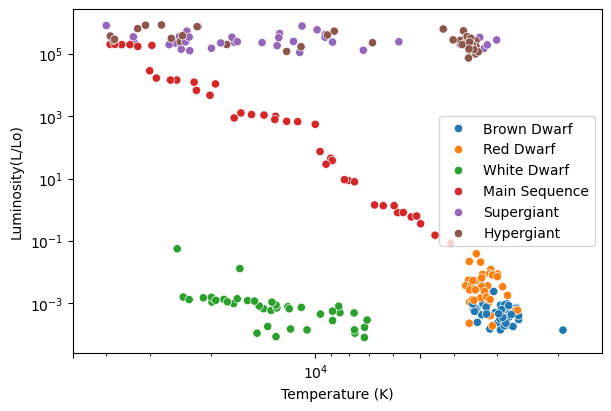

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), layout='constrained')

sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([5000, 10000, 50000])
ax.set_xlim(5e4, 1.5e3)

plt.show()

# 2 - PCA WITH NO RESCALING

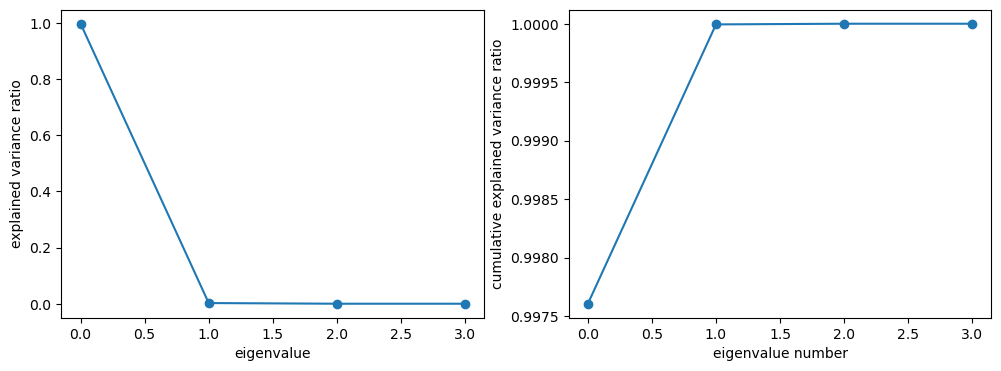

In [47]:
n_comp = 4

pca = PCA(n_comp=n_comp)

column = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
pca.fit(df_stars[column])
x = pca.fit_transform(df_stars[column])

evals = pca.explained_variance_ratio_

fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4))

ax.plot(np.arange(n_comp), evals)
ax.scatter(np.arange(n_comp), evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

bx.plot(np.arange(n_comp), evals.cumsum())
bx.scatter(np.arange(n_comp), evals.cumsum())

bx.set_xlabel("eigenvalue number")
bx.set_ylabel("cumulative explained variance ratio")

plt.show()

# 2 - PCA ON RESCALED DATA

In [85]:
# Rescale data

column = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df_stars[column])

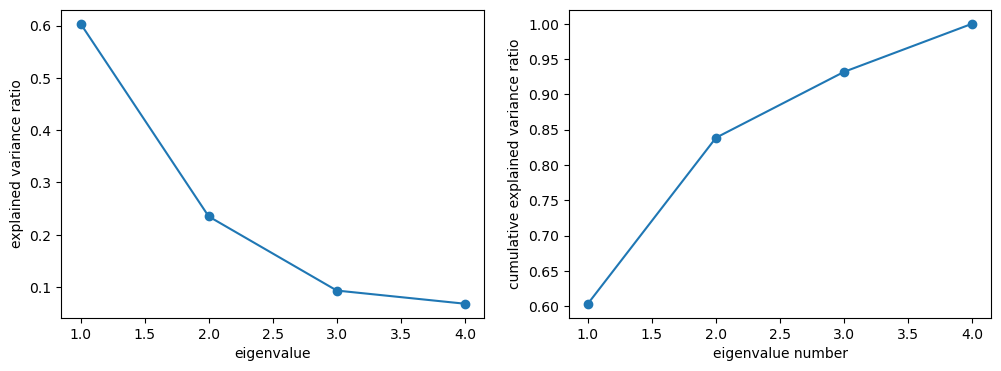

In [105]:
n_comp = 4

pca = PCA(n_comp=n_comp)
pca.fit(X_scaled)

evals = pca.explained_variance_ratio_

fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4))

ax.plot(np.arange(n_comp) + 1, evals)
ax.scatter(np.arange(n_comp) + 1, evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

bx.plot(np.arange(n_comp) + 1, evals.cumsum())
bx.scatter(np.arange(n_comp) + 1, evals.cumsum())

bx.set_xlabel("eigenvalue number")
bx.set_ylabel("cumulative explained variance ratio")

plt.show()

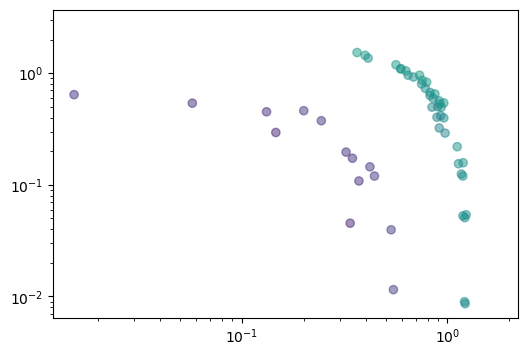

In [96]:
x_scaled = pca.transform(X_scaled)
x = x_scaled
comp = pca.components_
#scaler.inverse_transform(X_scaled)

evals = pca.explained_variance_ratio_

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(x[:, 0], x[:, 1], c=x[:, 3], alpha=.5)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (240,) and (4,)

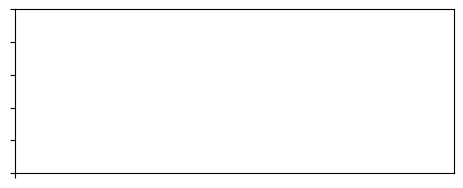

In [109]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'PCA components'
wavelengths = X_scaled[:, 0]


for j in range(n_comp):
    
    # plot the components
    ax = fig.add_subplot(n_comp, 2, 2*j+2)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    
    if j < n_comp - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel('wavelength (Angstroms)')
    ax.plot(wavelengths, comp[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

    # plot the first j spectra
    ax2 = fig.add_subplot(n_comp, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_comp - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel('wavelength (Angstroms)')
    ax2.plot(wavelengths, spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')
    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')

plt.show()